In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.distributions import Normal
from torch.utils.data import Subset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from torch.distributions import Categorical, Normal, StudentT
from torch.optim import SGD
from collections import deque
from tqdm import trange
import tqdm
import copy



In [2]:
# MNIST dataset
transform = transforms.Compose([torchvision.transforms.ToTensor()])
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [3]:
# subsample from trainset
n_subsamples_train = 2000 # size of subset
sub_train_idx = random.sample(range(60000),n_subsamples_train) # 60'000 is train size in MNSIT
sub_train_set = Subset(train_set, sub_train_idx)

# subsample from testset
n_subsamples_test = 1000  # size of subset
sub_test_idx = random.sample(range(10000), n_subsamples_test) # 10'000 is test size in MNIST
sub_test_set = Subset(test_set, sub_test_idx)

# load
#sub_train_dataloader = DataLoader(sub_train_set, batch_size=64, shuffle=True)
sub_test_dataloader = DataLoader(sub_test_set, batch_size=64, shuffle=False)


7


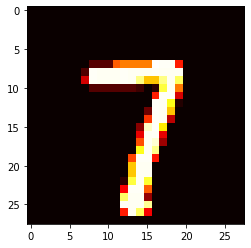

5


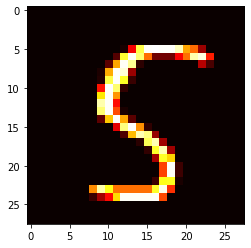

In [4]:
# Quick Check 
feature_test = sub_test_set[999][0]
label_test = sub_test_set[999][1]
print(label_test)
plt.imshow(feature_test.squeeze(), cmap='hot')
plt.show()


feature_train = sub_train_set[1999][0]
label_train = sub_train_set[1999][1]
print(label_train)
plt.imshow(feature_train.squeeze(), cmap='hot')
plt.show()


    Model Part Krause

In [5]:
# Create Class for Priors

class Prior:
    def __init__(self):
        pass
    def sample(self,n):
        pass
    def log_likelihood(self,values):
        pass

In [6]:
# Create Gaussian Prior
# Change: to a subclass of Prior

class IsotropicGaussian(Prior):
    def __init__(self, mean=0, std=1):
        super(IsotropicGaussian,self).__init__()
        self.mean = mean
        self.std = std

    def sample(self, n):
        return np.random.normal(self.mean, self.std, size=n)

    def log_likelihood(self, weights):
        return Normal(self.mean, self.std).log_prob(torch.tensor(weights)).sum()


In [7]:
# Fully Connected Neural Network 

class FullyConnectedNN(nn.Module):
    def __init__(self, in_features = 28*28, out_features = 10, hidden_units = 100, hidden_layers = 3):
        super().__init__()
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(in_features, hidden_units))
        for i in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_units, hidden_units))
        self.output_layer = nn.Linear(hidden_units, out_features)

    def forward(self, x):
        x = x.reshape(-1,28*28)
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        class_probs = self.output_layer(x)
        return class_probs

In [8]:
# Framework

class Framework(object):
    def __init__(self, training_set, *args, **kwargs):
        """
        Basic Framework for your bayesian neural network.
        SGLD will be based on this.
        """
        self.train_set = training_set
        self.print_interval = 64 # number of batches until updated metrics are displayed during training

    def train(self):
        raise NotImplementedError()

    def predict(self, data_loader: torch.utils.data.DataLoader) -> np.ndarray:
        """
        Predict the class probabilities using your trained model.
        This method should return an (num_samples, 10) NumPy float array
        such that the second dimension sums up to 1 for each row.

        :param data_loader: Data loader yielding the samples to predict on
        :return: (num_samples, 10) NumPy float array where the second dimension sums up to 1 for each row
        """
        probability_batches = []
        
        for batch_x, _ in tqdm.tqdm(data_loader):
            current_probabilities = self.predict_probabilities(batch_x).detach().numpy()
            probability_batches.append(current_probabilities)

        output = np.concatenate(probability_batches, axis=0)
        assert isinstance(output, np.ndarray)
        assert output.ndim == 2 and output.shape[1] == 10
        assert np.allclose(np.sum(output, axis=1), 1.0)
        return output

    def predict_probabilities(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError()

In [9]:
class SGLD(SGD):
    """Implementation of SGLD algorithm.

    Paper: "Bayesian Learning via Stochastic Gradient Langevin Dynamics", Welling & Teh, 2011.
    ----------
        
    """
    @torch.no_grad()
    def step(self, closure=None):
        """See `torch.optim.step’."""
        loss = super().step(closure)
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            for p in group['params']:
                if p.grad is None:
                    continue
                grad_p = p.grad.data
                #log_prior_weights = prior.log_likelihood(p.data)    # LOG_LIKELIHOOD OF WEIGHTS WITH PRIOR DISTRIBUTION
                #cost_and_regular = grad_p + log_prior_weights      # SUM OF THE TWO
                if weight_decay!=0:
                    grad_p.add_(alpha=weight_decay,other=p.data)
                langevin_noise = torch.randn_like(p.data).mul_(group['lr']**0.5)*0.1 #  use weight 0.1 to balance the noise
                p.data.add_(grad_p,alpha=-0.5*group['lr'])
                #p.data.add_(cost_and_regular,alpha=-0.5*group['lr'])
                if torch.isnan(p.data).any(): 
                    exit('Exist NaN param after SGLD, Try to tune the parameter')
                if torch.isinf(p.data).any(): 
                    exit('Exist Inf param after SGLD, Try to tune the parameter')
                p.data.add_(langevin_noise)
        return loss


# LOOK AT SKRIPT PAI AT PAGE 130/118 FOR THE ALGORITHM TO IMPLEMENT IT BY YOURSELF #

In [23]:
class SGLDTrainer(Framework):
    def __init__(self, dataset_train, prior = IsotropicGaussian(), *args, **kwargs):
        super().__init__(dataset_train, *args, **kwargs)

        # Hyperparameters and general parameters
        self.batch_size = 128
        self.learning_rate = 1e-3
        self.num_epochs = 500
        self.burn_in = 100
        self.sample_interval = 2
        self.max_size = 100
        
        self.data_loader = DataLoader(dataset_train, batch_size=64, shuffle=True)

        # Set Prior
        self.prior = prior

        # Initialize the SGLD network
        self.network = FullyConnectedNN()

        # SGLD optimizer is provided
        self.optimizer = SGLD(self.network.parameters(), lr=self.learning_rate)

        # Deque to store model samples
        self.SGLDSequence = deque()

    def train(self):
        num_iter = 0
        print('Training model')

        self.network.train()
        progress_bar = trange(self.num_epochs)

        for _ in progress_bar:
            num_iter += 1

            N = len(self.data_loader)

            for batch_idx, (batch_x, batch_y) in enumerate(self.data_loader):
                self.network.zero_grad()
                n = len(batch_x)

                # Perform forward pass
                current_logits = self.network(batch_x)

                # Calculate log_likelihood of weights for a given prior

                parameters = self.network.state_dict()     # extract weights from network
                param_values = list(parameters.values())    # list weights
                param_flat = np.concatenate([v.flatten() for v in param_values])    # flattern
                log_likelihood = self.prior.log_likelihood(param_flat)              # calculate log_lik

                # Calculate the loss
                loss = N/n*F.nll_loss(F.log_softmax(current_logits, dim=1), batch_y) - log_likelihood

                if batch_idx % self.print_interval == 0:
                    current_logits = self.network(batch_x)
                    current_accuracy = (current_logits.argmax(axis=1) == batch_y).float().mean()
                    progress_bar.set_postfix(loss=loss.item(), acc=current_accuracy.item())

                # Backpropagate to get the gradients
                loss.backward()

                self.optimizer.step()

            
            # Save the model samples if past the burn-in epochs and reached a regular sampling interval
            if num_iter > self.burn_in and num_iter % self.sample_interval == 0:
                self.SGLDSequence.append(copy.deepcopy(self.network))
                # self.network.state_dict()

            # If the deque exceeds the maximum size, delete the oldest model
            if len(self.SGLDSequence) > self.max_size:
                self.SGLDSequence.popleft()

    def predict_probabilities(self, x: torch.Tensor) -> torch.Tensor:
        #assert x.shape[1] == 28 ** 2
        self.network.eval()

        # Obtain the prediction from each network in SGLDSequence and combine the predictions
        estimated_probability = torch.zeros((len(x), 10))
        for model in self.SGLDSequence:


            self.network.load_state_dict(model.state_dict())
            logits = self.network(x).detach()
            estimated_probability += F.softmax(logits, dim=1)
        
        # Normalize the combined predictions
        estimated_probability /= len(self.SGLDSequence)

        assert estimated_probability.shape == (x.shape[0], 10)  
        return estimated_probability



In [24]:
lol = SGLDTrainer(sub_train_set)
lol.train()

Training model


100%|██████████| 500/500 [09:11<00:00,  1.10s/it, acc=0.781, loss=9.96e+4]


In [25]:
# test set
x_test = sub_test_set.dataset.data.float()
y_test = sub_test_set.dataset.targets

# predicted probabilities
class_probs = lol.predict_probabilities(x_test)

# accuracy
accuracy = (class_probs.argmax(axis=1) == y_test).float().mean()
print(f'Test Accuracy: {accuracy.item():.4f}')

Test Accuracy: 0.7703


In [26]:
# Calibration
import torchmetrics
from torchmetrics.functional import calibration_error

calib_err = calibration_error(class_probs, y_test, n_bins = 30, task = "multiclass", norm="l1", num_classes=10)
print(f'Calibration Error: {calib_err.item():.4f}')

Calibration Error: 0.0295


Train with StudentT Prior

In [54]:
class StudentTPrior(Prior):
    """
    Student-T Prior
    """
    def __init__(self, df=10, loc=0, scale=1, Temperature: float= 1.0):
        super().__init__()
        self.df = df
        self.loc = loc
        self.scale = scale
        self.Temperature = Temperature

    def log_likelihood(self, values) -> torch.Tensor:
        return StudentT(self.df, self.loc, self.scale).log_prob(torch.tensor(values)).sum() / self.Temperature

    def sample(self,n):
        return StudentT(self.df, self.loc, self.scale).sample((n,))  # sample from student-T

In [56]:
student_lol = SGLDTrainer(sub_train_set, prior=StudentTPrior())
student_lol.train()

Training model


100%|██████████| 500/500 [09:52<00:00,  1.19s/it, acc=0.844, loss=1.03e+5]


In [57]:
# predicted probabilities
class_probs_t = student_lol.predict_probabilities(x_test)

# accuracy
accuracy = (class_probs_t.argmax(axis=1) == y_test).float().mean()
print(f'Test Accuracy: {accuracy.item():.4f}')

Test Accuracy: 0.7844


In [58]:
calib_err = calibration_error(class_probs_t, y_test, n_bins = 30, task = "multiclass", norm="l1", num_classes=10)
print(f'Calibration Error: {calib_err.item():.4f}')

Calibration Error: 0.0258
